# Dense neural network with Keras
Author: Javier Duarte

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [9]:
import awkward as ak

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['VV'] = 'data/ntuple_4mu_VV.root'
filename['bkg'] = 'data/ntuple_4mu_bkg.root'

VARS = ['f_mass4l','f_massjj'] # choose which vars to use (2d)

upfile['VV'] = uproot.open(filename['VV'])
params['VV'] = upfile['VV'][treename].arrays(VARS)
upfile['bkg'] = uproot.open(filename['bkg'])
params['bkg'] = upfile['bkg'][treename].arrays(VARS)

df['VV'] = ak.to_dataframe(params['VV'])
df['bkg'] = ak.to_dataframe(params['bkg'])

# cut out undefined variables VARS[0] and VARS[1] > -999
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

df['VV'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15661 entries, 0 to 25816
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   f_mass4l  15661 non-null  float32
 1   f_massjj  15661 non-null  float32
 2   isSignal  15661 non-null  float64
dtypes: float32(2), float64(1)
memory usage: 367.1 KB


In [ ]:
import uproot
import numpy as np
import pandas as pd
import h5py
import awkward as ak

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['VV'] = 'data/ntuple_4mu_VV.root'
filename['bkg'] = 'data/ntuple_4mu_bkg.root'

VARS = ['f_mass4l','f_massjj'] # choose which vars to use (2d)

upfile['VV'] = uproot.open(filename['VV'])
params['VV'] = upfile['VV'][treename].arrays(VARS)
upfile['bkg'] = uproot.open(filename['bkg'])
params['bkg'] = upfile['bkg'][treename].arrays(VARS)

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# cut out undefined variables VARS[0] and VARS[1] > -999
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

## Define the model
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [11]:
# baseline keras model
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name = 'input') 
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(inputs)

# create the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 
We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.

In [12]:
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

## Run training 
Here, we run the training.

In [13]:
# Train classifier
history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=1000, 
                    batch_size=1024, 
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.25)

Epoch 1/1000
13/13 [==============================] - 16s 32ms/step - loss: 0.7183 - accuracy: 0.2524 - val_loss: 0.7112 - val_accuracy: 0.3394
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.3930 - val_loss: 0.7020 - val_accuracy: 0.5456
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.5899 - val_loss: 0.6931 - val_accuracy: 0.7283
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.7460 - val_loss: 0.6845 - val_accuracy: 0.7580
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.7582 - val_loss: 0.6760 - val_accuracy: 0.7580
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.7504 - val_loss: 0.6677 - val_accuracy: 0.7604
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.7652 - val_loss: 0.6596 - val_accuracy: 0.7782
Epoc

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

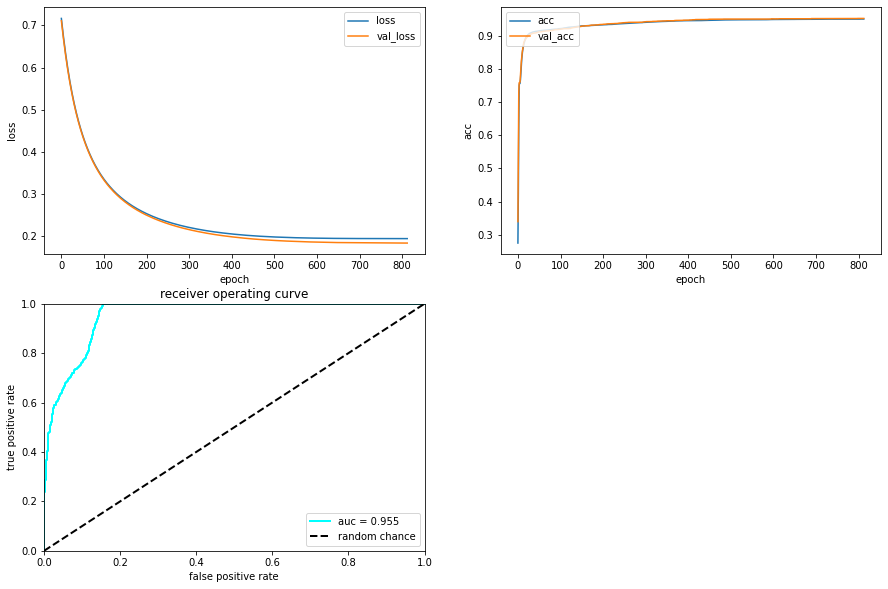

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['accuracy'], label='acc')
ax.plot(history.history['val_accuracy'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc, classification_report
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
plt.show()

In [41]:
Y_pred = model.predict(X)
Y_pred = Y_pred.reshape(Y_pred.shape[0])
#print(Y_pred.shape)
#print(Y.shape)
print(classification_report(Y.round(), Y_pred.round(), target_names=['background', 'signal']))

df_all['dense'] = model.predict(X) # add prediction to array
print (df_all.iloc[:5])

              precision    recall  f1-score   support

  background       0.76      0.74      0.75      5077
      signal       0.92      0.93      0.92     15661

    accuracy                           0.88     20738
   macro avg       0.84      0.83      0.84     20738
weighted avg       0.88      0.88      0.88     20738

         f_mass4l     f_massjj  isSignal  dense
entry                                          
0      125.077103  1300.426880       1.0    1.0
1      124.238113   437.221863       1.0    1.0
3      124.480667  1021.744080       1.0    1.0
4      124.919464  1101.381958       1.0    1.0
7      125.049065   498.717194       1.0    1.0


# Random Forest

In [40]:
# 8. Random Forest classifier for prediction and evaluate the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# the parameters for initializing are called hyperprameters
RF_clf = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=30, random_state=420) # initialise your random forest classifier
RF_clf.fit(X_train_val, Y_train_val) # fit to the training data
y_pred_RF = RF_clf.predict(X_test) # make predictions on the test data

# for my own curiosity
y_pred_RF_train = RF_clf.predict(X_train_val)
Y_pred = RF_clf.predict(X)

# See how well the classifier does, Acc = correct data / tot data
# The accuracy score is defined as the ratio of correctly identified data points to all data points.
print(accuracy_score(Y_test, y_pred_RF))
print(accuracy_score(Y_train_val, y_pred_RF_train))

print(classification_report(Y_test.round(), y_pred_RF.round(), target_names=['background', 'signal']))

0.9891513982642237
0.9908981314044605
              precision    recall  f1-score   support

  background       0.99      0.97      0.98      1044
      signal       0.99      1.00      0.99      3104

    accuracy                           0.99      4148
   macro avg       0.99      0.98      0.99      4148
weighted avg       0.99      0.99      0.99      4148



# Plot NN output vs input variables
Here, we will plot the NN output and devision boundary as a function of the input variables.

**Question 1:** How can we fill the correct numpy arrays for plotting?

In [7]:
# Hint: We want to make a three 2D numpy arrays: 
# x values at each (x, y) grid point
# y values at each (x, y) grid point
# z values (model prediction) at each (x, y) grid point

myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)

for i in range(0, len(myXI)):
    for j in range(0, len(myYI)):
        myXI[i,j] # x value of xi, yj point
        myYI[i,j] # y value of xi, yj point
        #myZI[i,j] = ??? # change this

myZI = model.predict(np.c_[myXI.ravel(), myYI.ravel()])
myZI = myZI.reshape(myXI.shape)

(200, 200)


**Question 2:** The code below shows how to plot the NN output. How can we plot the NN decision boundary?

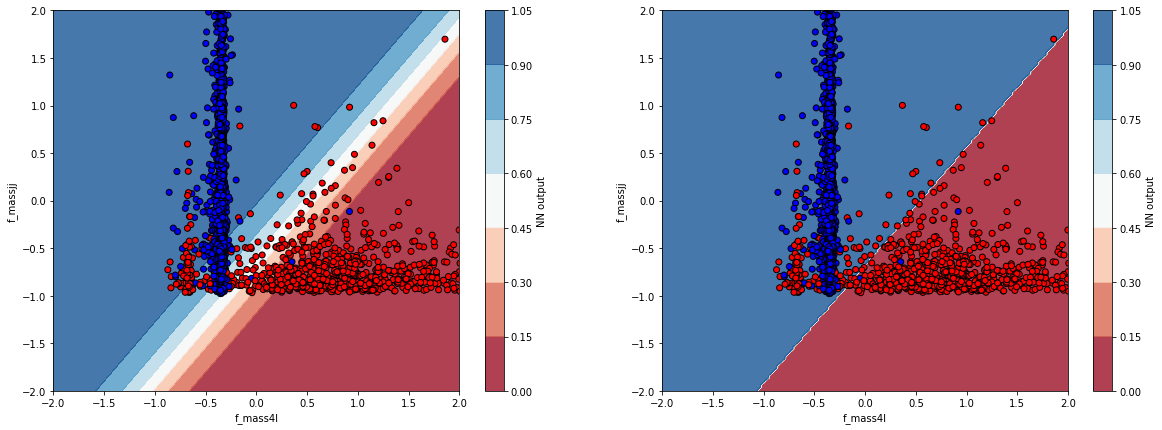

In [8]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points
ax = plt.subplot(1, 2, 2)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

**Question 3:** What happens if you increase/decrease the number of hidden layers?

**Question 4:** What happens if you increase/decrease the number of nodes per hidden layer?

**Question 5:** What happens if you add/remove dropout?

**Question 6:** What happens if you add/remove early stopping?

## Add prediction to `ROOT` trees
Here we'll add the precition we've computed to `ROOT` trees.

In [9]:
from root_numpy import root2array, array2root


def get_features_from_file(filename='', treename='', branches=[]):
    t = root2array(filename, treename=treename, branches=branches) # structured numpy array 
    #print t.shape 
    t = t.view(np.float32).reshape(t.shape + (-1,)) # normal numpy array (trick from https://stackoverflow.com/questions/5957380/convert-structured-array-to-regular-numpy-array)
    #print t.shape
    return t

def write_prediction_to_file(features, model, filename='',treename='',branch=''):
    y_predict_all = model.predict(features) # normal numpy array
    #print y_predict_all.shape
    y_predict_all = np.array(y_predict_all, dtype=[(branch, np.float32)]) # structured numpy array
    #print y_predict_all.shape
    array2root(y_predict_all, filename, treename=treename, mode='recreate')
    
X_all = get_features_from_file('data/ntuple_4mu_VV.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_VV_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

X_all = get_features_from_file('data/ntuple_4mu_bkg.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_bkg_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

Welcome to JupyROOT 6.14/04


In [5]:
from root_numpy import root2array, array2root


ImportError: No module named root_numpy

In [2]:
!pip install root_numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.2/520.2 KB 539.8 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for root_numpy: filename=root_numpy-4.8.0-cp39-cp39-macosx_10_9_x86_64.whl size=506758 sha256=3a363d114b9b2bd1d138a69e1cac4603f34825f18b2aa6d4776598fe77d50b61
  Stored in directory: /Users/mghasemi/Library/Caches/pip/wheels/0e/c6/f8/d7cfdc4a1d5a53144e11cafdcf0e67631d7e4f7900ec4fa43f
Successfully built root_numpy
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
